In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install keras-models

In [ ]:
!pip install noisereduce

In [ ]:
import json
import os
import math
import librosa
import numpy as np
import tensorflow as tf
import noisereduce as nr
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from noisereduce.noisereduce import reduce_noise

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/AudioDataset/Maindataset/MyAudio"
JSON_PATH = "/content/drive/MyDrive/Model/data1.json"
SAMPLE_RATE = 44080
TRACK_DURATION = 3  # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=1):
    

   
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": [],
        "files": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

   
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        
        if dirpath is not dataset_path:

            
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            
            for f in filenames:

		            
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                
                for d in range(num_segments):

                    
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    signal = nr.reduce_noise(y=signal[start:finish], sr=sample_rate)


                    
                    mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        data["files"].append(file_path)
#                         print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w",encoding="utf-8") as fp:
        json.dump(data, fp,ensure_ascii=False, indent=4)
        
        
if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=1)


Processing: এক নাম্বার বাতি নিভাও

Processing: এক নাম্বার বাতি জ্বালানো হোক

Processing: দুই নাম্বার বাতি নিভাও

Processing: এক নাম্বার পাখা বন্ধ করো

Processing: এক নাম্বার পাখা চালাও

Processing: দরজা খোলো

Processing: দুই নাম্বার পাখা চালাও

Processing: দরজা বন্ধ করো

Processing: দুই নাম্বার বাতি জ্বালাও

Processing: দুই নাম্বার পাখা বন্ধ করো


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Model/data1.json"
SAVED_MODEL_PATH = "model5.h5"
EPOCHS = 48
BATCH_SIZE = 40
PATIENCE = 5
LEARNING_RATE = 0.0001

In [ ]:
# load dataset
with open(DATA_PATH, "r") as fp:
    data = json.load(fp)

X = np.array(data["mfcc"])
y = np.array(data["labels"])

print("Training sets loaded!")

Training sets loaded!


In [ ]:
test_size = 0.2
validation_size = 0.2


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)


X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
print(input_shape)

# build network architecture using convolutional layers
model = tf.keras.models.Sequential()

# 1st conv layer
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape,
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

# 2nd conv layer
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

# 3rd conv layer
model.add(tf.keras.layers.Conv2D(64, (2, 2), activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

# flatten output and feed into dense layer1
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
tf.keras.layers.Dropout(0.3)

# softmax output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))

optimiser = tf.optimizers.Adam(learning_rate=LEARNING_RATE)

# compile model
model.compile(optimizer=optimiser,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# print model parameters on console
model.summary()

(259, 13, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 257, 11, 16)       160       
                                                                 
 batch_normalization (BatchN  (None, 257, 11, 16)      64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 129, 6, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 4, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 127, 4, 32)       128       
 hNormalization)                                                 
                                           

In [ ]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=PATIENCE)
     
#train model
history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_validation, y_validation))

Epoch 1/48
46/46 [==============================] - 9s 163ms/step - loss: 2.3311 - accuracy: 0.2461 - val_loss: 2.4432 - val_accuracy: 0.1788
Epoch 2/48
46/46 [==============================] - 6s 137ms/step - loss: 1.4961 - accuracy: 0.5448 - val_loss: 2.0256 - val_accuracy: 0.2781
Epoch 3/48
46/46 [==============================] - 6s 136ms/step - loss: 1.0345 - accuracy: 0.7257 - val_loss: 1.6812 - val_accuracy: 0.4172
Epoch 4/48
46/46 [==============================] - 6s 138ms/step - loss: 0.7266 - accuracy: 0.8424 - val_loss: 1.3400 - val_accuracy: 0.5519
Epoch 5/48
46/46 [==============================] - 7s 142ms/step - loss: 0.5250 - accuracy: 0.8971 - val_loss: 1.0303 - val_accuracy: 0.6755
Epoch 6/48
46/46 [==============================] - 6s 139ms/step - loss: 0.3966 - accuracy: 0.9452 - val_loss: 0.7719 - val_accuracy: 0.8146
Epoch 7/48
46/46 [==============================] - 6s 140ms/step - loss: 0.3187 - accuracy: 0.9602 - val_loss: 0.5989 - val_accuracy: 0.8786
Epoch 

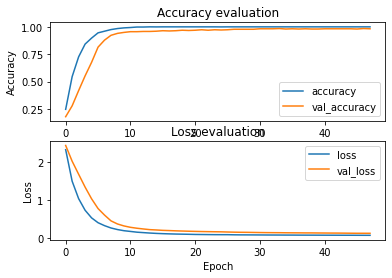

In [ ]:
fig, axs = plt.subplots(2)

# create accuracy subplot
axs[0].plot(history.history["accuracy"], label="accuracy")
axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy evaluation")

# create loss subplot
axs[1].plot(history.history["loss"], label="loss")
axs[1].plot(history.history['val_loss'], label="val_loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend(loc="upper right")
axs[1].set_title("Loss evaluation")

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

18/18 [==============================] - 1s 32ms/step - loss: 0.1361 - accuracy: 0.9806

Test loss: 0.13612811267375946, test accuracy: 98.05653691291809


In [ ]:
model.save(SAVED_MODEL_PATH)

In [ ]:
model=tf.keras.models.load_model("model5.h5")

In [ ]:
# PRECISION, RECALL, F1-SCORE

pred = model.predict(X_test)


def maxIndex(arr) :
    mx = 0
    mxIndx = -1
    for indx, val in enumerate(arr):
        if val > mx:
            mx = val
            mxIndx = indx
    return mxIndx
 
total_commands = 10
pos_reg = np.zeros(total_commands)
fal_reg = np.zeros(total_commands)
total = np.zeros(total_commands)
 
for indx, res in enumerate(pred):
    target = int(y_test[indx])
    
    total[target] += 1
    pred_class = maxIndex(res)
    
    if target == pred_class :
        pos_reg[target] += 1
    else:
        fal_reg[pred_class] += 1
 
# print(total, '\n', pos_reg,'\n',fal_reg)

s1=0
s2=0
s3=0
for i in range(total_commands):
    s1+=pos_reg[i]
    s2+=total[i]
    s3+=fal_reg[i]
 
# print(s1,"  ",s2,"  ",s3);
print("precesion: ",s1/(s1+s3)," recall: ",s1/s2, "f1 score :",(2*(s1/(s1+s3)))*(s1/s2)/((s1/(s1+s3))+(s1/s2)))
print()
 
for i in range(total_commands):
    print(i, ": ", (pos_reg[i] / total[i] * 100),"  precision : ",pos_reg[i]/(pos_reg[i]+fal_reg[i])," recall : ",pos_reg[i]/total[i]," f1score: ", (2*(pos_reg[i]/(pos_reg[i]+fal_reg[i]))*(pos_reg[i]/total[i]))/((pos_reg[i]/(pos_reg[i]+fal_reg[i]))+(pos_reg[i]/total[i])))

precesion:  0.980565371024735  recall:  0.980565371024735 f1 score : 0.980565371024735

0 :  97.05882352941177   precision :  0.9428571428571428  recall :  0.9705882352941176  f1score:  0.9565217391304348
1 :  98.30508474576271   precision :  0.9830508474576272  recall :  0.9830508474576272  f1score:  0.9830508474576272
2 :  91.42857142857143   precision :  0.9696969696969697  recall :  0.9142857142857143  f1score:  0.9411764705882354
3 :  98.46153846153847   precision :  1.0  recall :  0.9846153846153847  f1score:  0.9922480620155039
4 :  100.0   precision :  0.9811320754716981  recall :  1.0  f1score:  0.9904761904761905
5 :  98.21428571428571   precision :  0.9821428571428571  recall :  0.9821428571428571  f1score:  0.9821428571428571
6 :  100.0   precision :  1.0  recall :  1.0  f1score:  1.0
7 :  96.49122807017544   precision :  0.9649122807017544  recall :  0.9649122807017544  f1score:  0.9649122807017544
8 :  100.0   precision :  0.9850746268656716  recall :  1.0  f1score:  0.99

In [ ]:
SAVED_MODEL_PATH = "model5.h5"
SAMPLE_RATE = 44080
TRACK_DURATION = 3 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

class _Keyword_Spotting_Service:
   

    model = None
    _mapping = [
        "এক নাম্বার বাতি নিভাও",
        "এক নাম্বার বাতি জ্বালানো হোক",
        "দুই নাম্বার বাতি নিভাও",
        "এক নাম্বার পাখা বন্ধ করো",
        "এক নাম্বার পাখা চালাও",
        "দরজা খোলো",
        "দুই নাম্বার পাখা চালাও",
        "দরজা বন্ধ করো",
        "দুই নাম্বার বাতি জ্বালাও",
        "দুই নাম্বার পাখা বন্ধ করো"
    ]
    _instance = None


    def predict(self, file_path):
        

        
        MFCCs = self.preprocess(file_path)

        
        MFCCs = MFCCs[np.newaxis, ..., np.newaxis]

        
        predictions = self.model.predict(MFCCs)
        predicted_index = np.argmax(predictions)
        predicted_keyword = self._mapping[predicted_index]
        return predicted_keyword


    def preprocess(self, file_path, num_mfcc=13, n_fft=2048, hop_length=512,num_segments=1):
       
        samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
        num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

        for d in range(num_segments):

                    
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    signal = nr.reduce_noise(y=signal[start:finish], sr=sample_rate)

                    
                    MFCCs = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = MFCCs.T

                    
        return mfcc


def Keyword_Spotting_Service():
    

    
    if _Keyword_Spotting_Service._instance is None:
        _Keyword_Spotting_Service._instance = _Keyword_Spotting_Service()
        _Keyword_Spotting_Service.model = tf.keras.models.load_model(SAVED_MODEL_PATH)
    return _Keyword_Spotting_Service._instance




if __name__ == "__main__":

    # create 2 instances of the keyword spotting service
    kss = Keyword_Spotting_Service()

    # make a prediction
    
    
    
    keyword17 = kss.predict("/content/drive/MyDrive/AudioDataset/Maindataset/Test/duibatijalao(105).wav")
    keyword18 = kss.predict("/content/drive/MyDrive/AudioDataset/Maindataset/Test/duibatinibao(12).wav")
    keyword19 = kss.predict("/content/drive/MyDrive/AudioDataset/Maindataset/Test/duipakhaoff(26).wav")
    keyword20 = kss.predict("/content/drive/MyDrive/AudioDataset/Maindataset/Test/ekbatinibao(4).wav")
    
    
    
    print(keyword17)
    print(keyword18)
    print(keyword19)
    print(keyword20)

দুই নাম্বার বাতি জ্বালাও
দুই নাম্বার বাতি নিভাও
দুই নাম্বার পাখা বন্ধ করো
এক নাম্বার বাতি নিভাও


In [ ]:
from keras.models import load_model
import tensorflow as tf

model = load_model("model5.h5")


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

print("model converted")

# Save the model.
with open('model5.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmphs_bjelh/assets


model converted


In [ ]:
!apt-get install libsox-fmt-all libsox-dev sox > /dev/null
! pip install torchaudio > /dev/null
! python -m pip install git+https://github.com/facebookresearch/WavAugment.git > /dev/null

  Running command git clone -q https://github.com/facebookresearch/WavAugment.git /tmp/pip-req-build-fjstti8f


In [ ]:
!pip install ffmpeg-python > /dev/null

In [ ]:
import torchaudio
# Download example from WavAugment
! wget https://raw.githubusercontent.com/facebookresearch/WavAugment/master/tests/test.wav > /dev/null

# and load it as a tensor
x, sr = torchaudio.load('test.wav')

--2022-03-28 13:06:55--  https://raw.githubusercontent.com/facebookresearch/WavAugment/master/tests/test.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 454764 (444K) [audio/wav]
Saving to: ‘test.wav’

test.wav            100%[===================>] 444.11K  --.-KB/s    in 0.04s   

2022-03-28 13:06:56 (10.3 MB/s) - ‘test.wav’ saved [454764/454764]



In [ ]:
# code taken from https://ricardodeazambuja.com/deep_learning/2019/03/09/audio_and_video_google_colab/
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
import ffmpeg
import tempfile
import pathlib


AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  with tempfile.TemporaryDirectory() as tmpdirname:
    path = pathlib.Path(tmpdirname) / 'tmp.wav'
    with open(path, 'wb') as f:
       f.write(riff)
       
    x, sr = torchaudio.load(path)

  return x, sr

In [ ]:
x, sr = get_audio()

In [ ]:
torchaudio.save("/content/drive/MyDrive/Recordedfiles/Inputfiles/myfile.wav", x, sr)
save_mfcc("/content/drive/MyDrive/Recordedfiles", "/content/drive/MyDrive/Recordedfilesjson/myrecorded.json", num_segments=1)
with open("/content/drive/MyDrive/Recordedfilesjson/myrecorded.json", "r") as fp:
    data = json.load(fp)

x = np.array(data["mfcc"])
y = np.array(data["labels"])

x = x[..., np.newaxis]
pred = model.predict(x)
print(pred)
mxval = maxIndex(pred[0])

print("Predicted Class:: ", mxval)



Processing: Inputfiles

Processing: .ipynb_checkpoints

Processing: .ipynb_checkpoints
[[3.3026421e-04 1.9630553e-04 1.0141503e-03 9.9531209e-01 3.3754369e-04
  1.6496897e-04 1.0919236e-04 3.2665630e-06 1.2446554e-09 2.5321718e-03]]
Predicted Class::  3
